In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from matplotlib import pyplot as plt
from touch2touch.vq_vae.datasets_loading import logging_image_grid

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
gt_path = "/home/samanta/touch2touch/results/ground_truth"
models_path = "/home/samanta/touch2touch/results/models"
models_paths = ['vq_vae_rot_flip']
models_paths = [os.path.join(models_path, path) for path in models_paths]

### Visual Qualitative Results

vq_vae_rot_flip
test


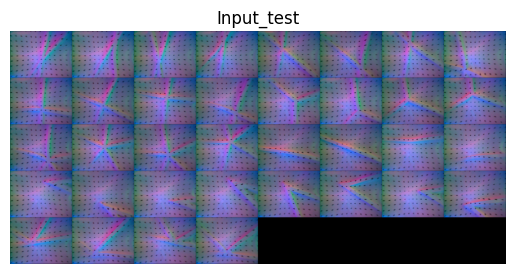

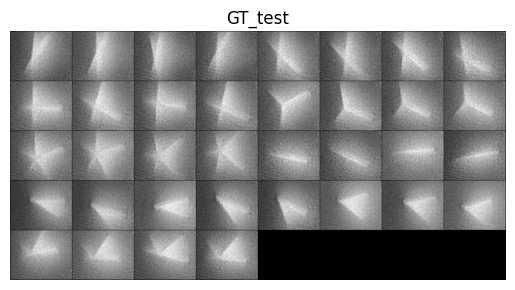

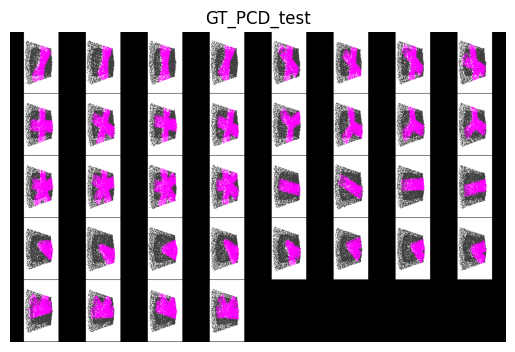

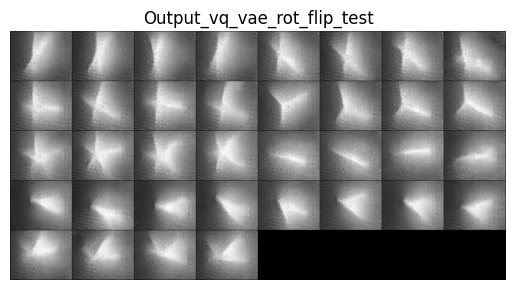

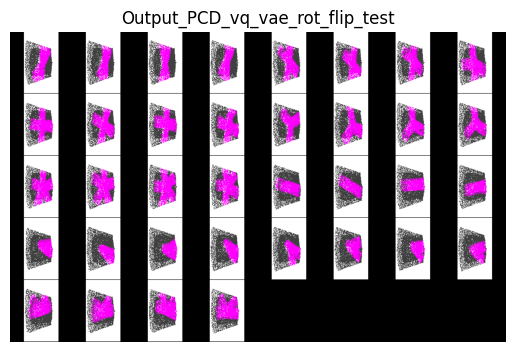

test_unseen


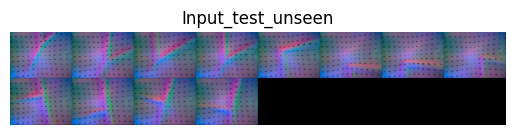

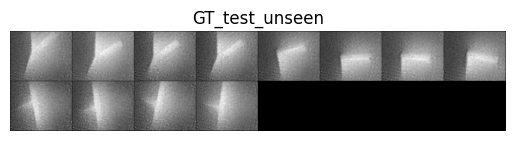

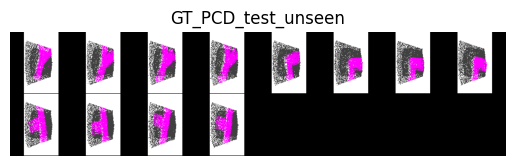

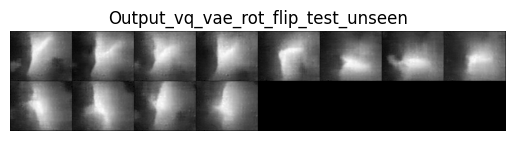

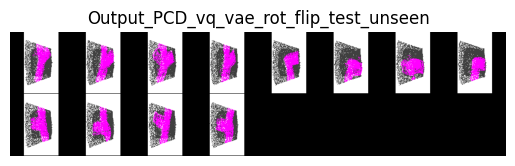

In [3]:
for i, model_path in enumerate(models_paths):
    model = model_path.split('/')[-1]
    print(model)
    datasets_paths = os.listdir(model_path)
    datasets_paths = [path for path in datasets_paths if os.path.isdir(os.path.join(model_path, path))]
    datasets_paths.sort()
    for dataset in datasets_paths:
        inputs = []
        gt = []
        gt_pcd = []
        pred = []
        pred_pcd = []
        dataset_path = os.path.join(model_path, dataset)
        print(dataset)
        tools_paths = os.listdir(dataset_path)
        tools_paths.sort()
        # tools_paths = tools_paths[:-1]
        for tool in tools_paths:
            tool_path = os.path.join(dataset_path, tool)
            tool_input = torch.load(os.path.join(tool_path, "visual_qualitative_results.pt"))['gelslim_input_viz_single']
            tool_gt = torch.load(os.path.join(tool_path, "visual_qualitative_results.pt"))['bubbles_gt_viz_single']
            tool_gt_pcd = torch.load(os.path.join(tool_path, "visual_qualitative_results.pt"))['bubbles_gt_pcd_viz'][:,:,:(256//2)]
            tool_pred = torch.load(os.path.join(tool_path, "visual_qualitative_results.pt"))['bubbles_pred_viz_single']
            tool_pred_pcd = torch.load(os.path.join(tool_path, "visual_qualitative_results.pt"))['bubbles_pred_pcd_viz'][:,:,:(256//2)]
            inputs.append(tool_input)
            gt.append(tool_gt)
            gt_pcd.append(tool_gt_pcd)
            pred.append(tool_pred)
            pred_pcd.append(tool_pred_pcd)
        inputs = torch.cat(inputs, dim=0)
        gt = torch.cat(gt, dim=0)
        gt_pcd = torch.cat(gt_pcd, dim=0)
        pred = torch.cat(pred, dim=0)
        pred_pcd = torch.cat(pred_pcd, dim=0)
        if i == 0:
            logging_image_grid([inputs, gt, gt_pcd], [f"Input_{dataset}", f"GT_{dataset}", f"GT_PCD_{dataset}"], '',save=False, ncol=8)
        logging_image_grid([pred, pred_pcd], [f"Output_{model}_{dataset}", f"Output_PCD_{model}_{dataset}"], "", save=False, ncol=8)

### Visual Quantitative Results

In [5]:
metrics_results = []
for i, model_path in enumerate(models_paths):
    model = model_path.split('/')[-1]
    datasets_paths = os.listdir(model_path)
    datasets_paths = [path for path in datasets_paths if os.path.isdir(os.path.join(model_path, path))]
    datasets_paths.sort()
    
    for dataset in datasets_paths:
        psnr_error = 0
        ssim_error = 0
        fid_error = 0
        mse_error = 0
        
        dataset_path = os.path.join(model_path, dataset)
        tools_paths = os.listdir(dataset_path)
        tools_paths.sort()
        for tool in tools_paths:
            tool_path = os.path.join(dataset_path, tool)
            metrics = torch.load(os.path.join(tool_path, "visual_quantitative_results.pt"))
            psnr_error += metrics['psnr_error'].item()
            ssim_error += metrics['ssim_error'].item()
            fid_error += metrics['fid_error'].item()
            mse_error += metrics['mse_error'].item()

        psnr_error /= len(tools_paths)
        ssim_error /= len(tools_paths)
        fid_error /= len(tools_paths)
        mse_error /= len(tools_paths)
        
        metrics_dict = {'method': model, 'dataset': dataset, 'psnr_error': psnr_error, 'ssim_error': ssim_error, 'fid_error': fid_error}
        metrics_results.append(metrics_dict)

metrics_df = pd.DataFrame(metrics_results)
filtered_df = metrics_df[metrics_df['dataset'] == 'train']
pd.set_option('display.precision', 2)
print('Train')
print(filtered_df)
print('\n\n')

filtered_df = metrics_df[metrics_df['dataset'] == 'test']
pd.set_option('display.precision', 2)
print('Test')
print(filtered_df)
print('\n\n')

filtered_df = metrics_df[metrics_df['dataset'] == 'test_unseen']
pd.set_option('display.precision', 2)
print('Test Unseen')
print(filtered_df)
print('\n\n')

Train
Empty DataFrame
Columns: [method, dataset, psnr_error, ssim_error, fid_error]
Index: []



Test
            method dataset  psnr_error  ssim_error  fid_error
0  vq_vae_rot_flip    test       27.01        0.57      144.2



Test Unseen
            method      dataset  psnr_error  ssim_error  fid_error
1  vq_vae_rot_flip  test_unseen       20.73        0.37     212.78





### Functional Quantitative Results

In [ ]:
metrics_results = []
for i, model_path in enumerate(models_paths):
    model = model_path.split('/')[-1]
    datasets_paths = os.listdir(model_path)
    datasets_paths = [path for path in datasets_paths if os.path.isdir(os.path.join(model_path, path))]
    datasets_paths.sort()
    
    for dataset in datasets_paths:
        mean_avg = 0
        std_avg = 0
        acc_5 = 0
        acc_10 = 0
        time = 0
        dataset_path = os.path.join(model_path, dataset)
        tools_paths = os.listdir(dataset_path)
        tools_paths.sort()
        for tool in tools_paths:
            tool_path = os.path.join(dataset_path, tool)
            metrics = torch.load(os.path.join(tool_path, "functional_results.pt"))['pred_results']
            mean_avg += metrics['pred_cal_mean']
            std_avg += metrics['pred_cal_std']**2
            acc_5 += metrics['pred_cal_acc_5']
            acc_10 += metrics['pred_cal_acc_10']

        mean_avg = mean_avg/len(tools_paths)
        std_avg = np.sqrt(std_avg/len(tools_paths))
        acc_5 = acc_5/len(tools_paths)
        acc_10 = acc_10/len(tools_paths)

        metrics_dict = {'method': model, 'dataset': dataset, 'mean_avg': mean_avg, 'std_avg': std_avg, 'acc_5': acc_5, 'acc_10': acc_10}
        metrics_results.append(metrics_dict)

metrics_df = pd.DataFrame(metrics_results)
filtered_df = metrics_df[metrics_df['dataset'] == 'train']
pd.set_option('display.precision', 2)
print('Train')
print(filtered_df)
print('\n\n')

filtered_df = metrics_df[metrics_df['dataset'] == 'test']
pd.set_option('display.precision', 2)
print('Test')
print(filtered_df)
print('\n\n')

filtered_df = metrics_df[metrics_df['dataset'] == 'test_unseen']
pd.set_option('display.precision', 2)
print('Test Unseen')
print(filtered_df)
print('\n\n')

Train
                             method dataset  mean_avg  std_avg  acc_5  acc_10
2  vq_vae_new_partial_data_rot_flip   train      1.23      0.9  99.76   100.0



Test
                             method dataset  mean_avg  std_avg  acc_5  acc_10
0  vq_vae_new_partial_data_rot_flip    test       1.4     1.18   97.1   100.0



Test Unseen
                             method      dataset  mean_avg  std_avg  acc_5  \
1  vq_vae_new_partial_data_rot_flip  test_unseen      8.39    10.63  40.58   

   acc_10  
1   73.19  



